In [3]:
#importing relevant packages
import torch
from torch import nn
import os
from tqdm.auto import tqdm

In [4]:
#choose gpu
device = 'cuda'
import os
os.chdir("c:\\Users\\Liuxi\\OneDrive\\桌面\\cosi165b_final_project\\code")

In [5]:
from cycleGAN import *

In [12]:
class GAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_ptm = Generator(in_ch, out_ch)
        self.disc_m = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(self.gen_ptm.parameters(), lr = start_lr)
        self.adam_disc = torch.optim.Adam(self.disc_m.parameters(), lr=start_lr, betas=(0.5, 0.999))
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        disc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.disc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_disc, disc_lr.step)
        self.gen_stats = AvgStats()
        self.disc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_ptm)
        init_weights(self.disc_m)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.disc_m = self.disc_m.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_disc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.disc_m], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_monet = self.gen_ptm(photo_img)
                monet_fake_disc = self.disc_m(fake_monet)
                gen_fake_loss = self.mse_loss(monet_fake_disc, torch.ones_like(monet_fake_disc)) 

                real_monet = self.gen_ptm(monet_img)
                idt_loss_monet = self.l1_loss(real_monet, monet_img) * self.lmbda * self.idt_coef
                
                gen_loss = (gen_fake_loss + idt_loss_monet) / 2

                avg_gen_loss += gen_loss.item()
                gen_loss.backward()
                self.adam_gen.step()

                update_req_grad([self.disc_m], True)
                self.adam_disc.zero_grad()
                fake_monet = self.gen_ptm(photo_img)

                fake_pred = self.disc_m(fake_monet)
                disc_fake_loss = self.mse_loss(fake_pred, torch.zeros_like(fake_pred))
                
                real_monet_pred = self.disc_m(monet_img)
                disc_real_loss = self.mse_loss(real_monet_pred, torch.ones_like(real_monet_pred))
                disc_loss = (disc_fake_loss + disc_real_loss) / 2
                avg_disc_loss += disc_loss.item()
                disc_loss.backward()
                self.adam_disc.step()
                
                t.set_postfix(gen_loss=gen_loss.item(), disc_loss=disc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_ptm': gan.gen_ptm.state_dict(),
                'disc_m': gan.disc_m.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_disc': gan.adam_disc.state_dict()
            }
            save_checkpoint(save_dict, 'current_regularGAN.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_disc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.disc_stats.append(avg_disc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_disc_loss))
      
            self.gen_lr_sched.step()
            self.disc_lr_sched.step()

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:1.112913 | Discriminator Loss:0.468369


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:0.907813 | Discriminator Loss:0.255750


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:0.885859 | Discriminator Loss:0.242506


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:0.859367 | Discriminator Loss:0.228620


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:0.874118 | Discriminator Loss:0.227474


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:0.881404 | Discriminator Loss:0.221330


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:0.869688 | Discriminator Loss:0.241107


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:0.832795 | Discriminator Loss:0.235500


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:0.803183 | Discriminator Loss:0.253207


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:0.761510 | Discriminator Loss:0.247405


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:0.773126 | Discriminator Loss:0.249611


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:0.778874 | Discriminator Loss:0.253080


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:0.763183 | Discriminator Loss:0.251201


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:0.750109 | Discriminator Loss:0.249432


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:0.743811 | Discriminator Loss:0.253932


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:0.704495 | Discriminator Loss:0.255100


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:0.695808 | Discriminator Loss:0.258175


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:0.674020 | Discriminator Loss:0.259928


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:0.677479 | Discriminator Loss:0.260632


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:0.685031 | Discriminator Loss:0.258323


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:0.647781 | Discriminator Loss:0.255848


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:0.667598 | Discriminator Loss:0.258763


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:0.658038 | Discriminator Loss:0.258128


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:0.639381 | Discriminator Loss:0.262360


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:0.624027 | Discriminator Loss:0.259424


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:0.633228 | Discriminator Loss:0.259221


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:0.631444 | Discriminator Loss:0.259032


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:0.617204 | Discriminator Loss:0.252206


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:0.610128 | Discriminator Loss:0.249620


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:0.621860 | Discriminator Loss:0.243058


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (31) | Generator Loss:0.597113 | Discriminator Loss:0.251567


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (32) | Generator Loss:0.610310 | Discriminator Loss:0.245971


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (33) | Generator Loss:0.594850 | Discriminator Loss:0.245281


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (34) | Generator Loss:0.583507 | Discriminator Loss:0.242239


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (35) | Generator Loss:0.591619 | Discriminator Loss:0.241780


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (36) | Generator Loss:0.585501 | Discriminator Loss:0.232139


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (37) | Generator Loss:0.584378 | Discriminator Loss:0.239521


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (38) | Generator Loss:0.580502 | Discriminator Loss:0.235151


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (39) | Generator Loss:0.561741 | Discriminator Loss:0.236855


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (40) | Generator Loss:0.555353 | Discriminator Loss:0.229285


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (41) | Generator Loss:0.569096 | Discriminator Loss:0.221894


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (42) | Generator Loss:0.564535 | Discriminator Loss:0.219698


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (43) | Generator Loss:0.562332 | Discriminator Loss:0.214569


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (44) | Generator Loss:0.549977 | Discriminator Loss:0.213997


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (45) | Generator Loss:0.545612 | Discriminator Loss:0.211349


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (46) | Generator Loss:0.544552 | Discriminator Loss:0.205273


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (47) | Generator Loss:0.541170 | Discriminator Loss:0.201362


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (48) | Generator Loss:0.533895 | Discriminator Loss:0.203760


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (49) | Generator Loss:0.535220 | Discriminator Loss:0.199201


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (50) | Generator Loss:0.530512 | Discriminator Loss:0.191584


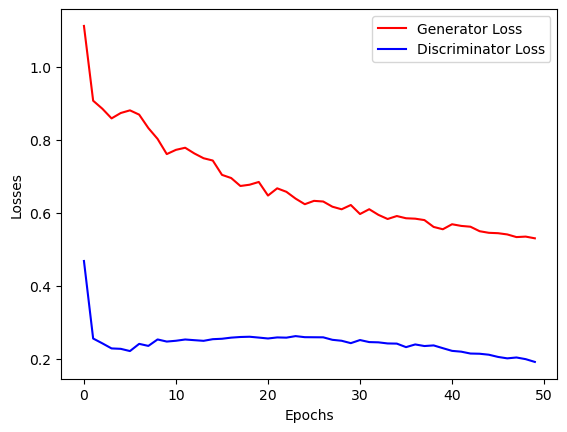

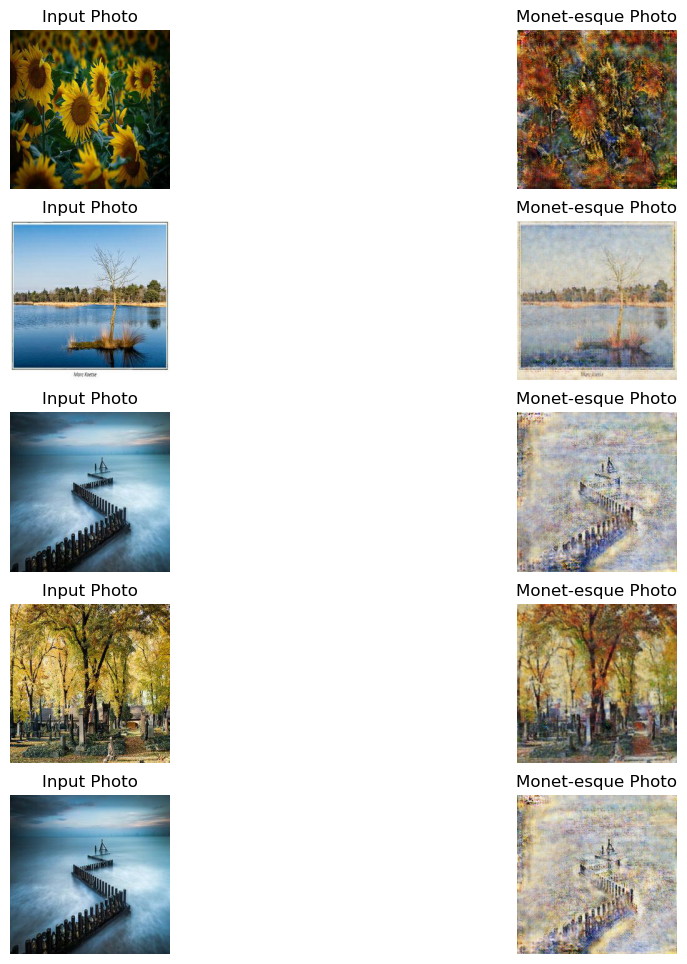

In [20]:
if __name__ == "__main__":

    gan = GAN(3, 3, 50, device)

    # Save before train
    save_dict = {
        'epoch': 0,
        'gen_ptm': gan.gen_ptm.state_dict(),
        'disc_m': gan.disc_m.state_dict(),
        'optimizer_gen': gan.adam_gen.state_dict(),
        'optimizer_disc': gan.adam_disc.state_dict()
    }
    save_checkpoint(save_dict, 'init.ckpt')

    gan.train(img_dl)


    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
    plt.plot(gan.disc_stats.losses, 'b', label='Discriminator Loss')
    plt.legend()
    plt.show()


    _, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i in range(5):
        photo_img, _ = next(iter(img_dl))
        pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
        photo_img = unnorm(photo_img)
        pred_monet = unnorm(pred_monet)
        
        ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
        ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque Photo")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()